# Census Population Data (2020) + NYC Tree Census Data (2015)

### Tress per capita (by Census Tract) 

### STATEN ISLAND

In [125]:
# load libraries
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import pysal as ps
import libpysal
import esda
from pysal.lib import weights
from splot.esda import plot_moran
from splot.esda import plot_local_autocorrelation

In [126]:
# read in data
trees_cts = gpd.read_file("data/trees_cts.geojson")

In [127]:
trees_cts.head()

,GEOID,population,census tract,county,tree_count,trees_per_capita,area_per_sqmile,trees_per_sqmile,geometry
0,36005012701,1664.0,127.01,Bronx,201.0,0.120793,0.041620,4829.377806,"POLYGON ((-7129744.449 4787818.802, -7129654.2..."
1,36005037300,4365.0,373,Bronx,211.0,0.048339,0.066843,3156.671549,"POLYGON ((-7129604.833 4789904.712, -7129520.2..."
2,36005011900,4276.0,119,Bronx,247.0,0.057764,0.063114,3913.558552,"POLYGON ((-7129505.357 4787665.982, -7129427.7..."
3,36005039100,5255.0,391,Bronx,364.0,0.069267,0.079709,4566.636743,"POLYGON ((-7129221.590 4790683.165, -7129136.5..."
4,36005007900,4957.0,79,Bronx,297.0,0.059915,0.076384,3888.228621,"POLYGON ((-7131068.335 4786855.710, -7130944.4..."


In [128]:
# check county names
print(trees_cts['county'].drop_duplicates().to_list())

['Bronx', 'Kings', 'Queens', 'Richmond', 'New York']


In [129]:
# look at only Staten Island
SI_trees_cap = trees_cts.query("county == 'Richmond'")

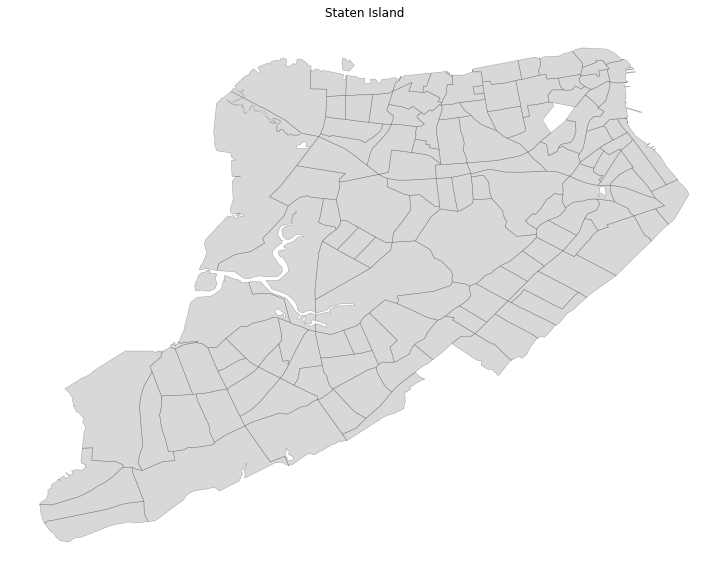

In [134]:
# check plot

# create a figure with one subplot
fig, ax = plt.subplots(figsize=(20,10))

# plot census tracts
SI_trees_cap.plot(ax = ax, alpha = 0.3, edgecolor = 'black', linewidth = 0.5, color = 'gray')

ax.axis('off')
ax.set(title = 'Staten Island')
       
plt.savefig("maps/StatenIsland/Staten-Island_CTs.pdf")

In [135]:
# first - drop cells containing Null values (cells containing zero points) - or code will not work
SI_trees_cap = SI_trees_cap.dropna(subset = ['trees_per_capita'])

In [136]:
# drop trees per capita with 0
SI_trees_cap = SI_trees_cap.query("trees_per_capita > 0")

In [137]:
# create queen contiguity weights
w_SI = weights.Queen.from_dataframe(SI_trees_cap)

In [139]:
# fill in islands with KNN weights
w_knn_SI = weights.KNN.from_dataframe(SI_trees_cap, k=1)

In [140]:
w_SI = weights.attach_islands(w_SI, w_knn_SI)

There are no disconnected observations (no islands)!


In [141]:
# row standardize weights
w_SI.transform = 'R'

## Spatial Autocorrelation - Local Moran's I
### *removed all census tracts with 0 trees per capita*

In [142]:
# on trees per capita
local_moran_SI = esda.moran.Moran_Local(SI_trees_cap['trees_per_capita'], w_SI)

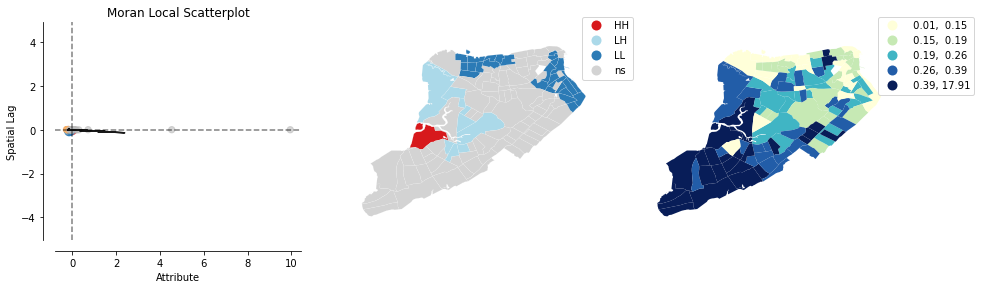

In [144]:
# plot results (at p < 0.05)
plot_local_autocorrelation(local_moran_SI, SI_trees_cap,'trees_per_capita', p = 0.05 );

plt.savefig("maps/StatenIsland/Staten-Island_Trees-per-Capita_moran.pdf")

In [145]:
# get clusters and outliers - adding columns to the DF

SI_trees_cap['local_moran_Is'] = local_moran_SI.Is
SI_trees_cap['local_moran_p_value'] = local_moran_SI.p_sim
SI_trees_cap['local_moran_quadrant'] = local_moran_SI.q

In [146]:
# get statisically significant clusters and outliers

alpha = 0.05
hotspots_SI = SI_trees_cap.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots_SI = SI_trees_cap.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
doughnuts_SI = SI_trees_cap.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
diamonds_SI = SI_trees_cap.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")

/Users/djferrera/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


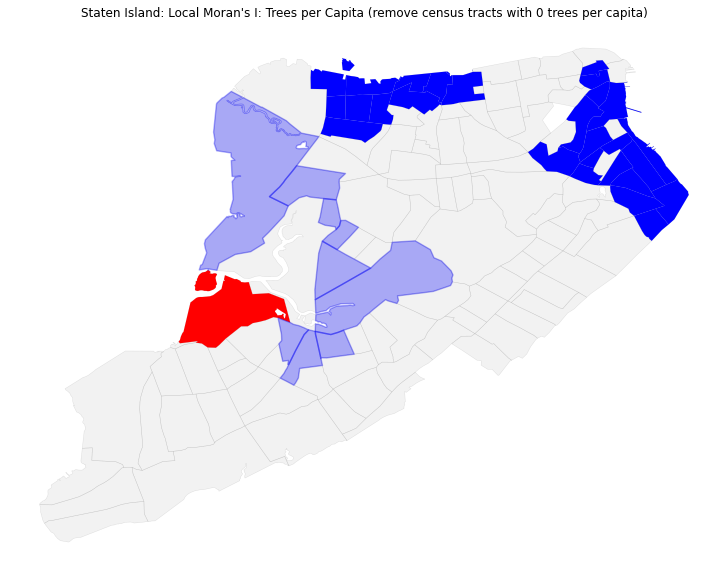

In [147]:
# view clusters and outliers

# create a figure with one subplot
fig, ax = plt.subplots(figsize=(20,10))

# plot census tracts
SI_trees_cap.plot(ax = ax, alpha = 0.1, edgecolor = 'black', linewidth = 0.5, color = 'gray')

# plot HH / LL / HL / LH
SI_trees_cap.plot(ax = ax, facecolor = 'none', alpha = 0)
hotspots_SI.plot(color = 'red', ax = ax, label = 'Hot Spot')
coldspots_SI.plot(color = 'blue', ax = ax, label = 'Cold Spot')
doughnuts_SI.plot(color = 'blue', alpha = 0.3, edgecolor = 'blue', linewidth = 1.5, ax = ax, label = 'Doughnuts')
diamonds_SI.plot(color = 'red', alpha = 0.3, edgecolor = 'red', linewidth = 1.5, ax = ax, label = 'Diamonds')

ax.axis('off')
ax.set(title = "Staten Island: Local Moran's I: Trees per Capita (remove census tracts with 0 trees per capita)")

plt.savefig("maps/StatenIsland/Staten-Island_Trees-per-Capita.pdf")

### *investigate the numbers*

In [202]:
# look at smallest values
SI_trees_cap['trees_per_capita'].nsmallest(n=10)

739     0.005698
579     0.023878
2201    0.061693
586     0.064635
1866    0.072678
467     0.089985
2147    0.098502
1189    0.106117
1204    0.110969
1064    0.114364
Name: trees_per_capita, dtype: float64

In [161]:
# look at largest values
SI_trees_cap['trees_per_capita'].nlargest(n=10)

792     17.909091
154      8.428571
1814     1.735294
1682     0.994242
1202     0.805266
434      0.730858
185      0.663545
580      0.632592
187      0.619146
1074     0.562518
Name: trees_per_capita, dtype: float64

In [150]:
# lowest 1% of data
print(SI_trees_cap['trees_per_capita'].quantile(q = 0.01))

0.032197095205403425


In [151]:
# lowest 5% of data
print(SI_trees_cap['trees_per_capita'].quantile(q = 0.05))

0.09926367744812511


In [152]:
# lowest 10% of data
print(SI_trees_cap['trees_per_capita'].quantile(q = 0.10))

0.12347727924378796


In [153]:
# lowest 20% of data
print(SI_trees_cap['trees_per_capita'].quantile(q = 0.20))

0.15218989736150684


In [154]:
# highest 1% of data
print(SI_trees_cap['trees_per_capita'].quantile(q = 0.99))

6.956050420168075


In [155]:
# highest 5% of data
print(SI_trees_cap['trees_per_capita'].quantile(q = 0.95))

0.6604493579646187


In [156]:
# highest 10% of data
print(SI_trees_cap['trees_per_capita'].quantile(q = 0.90))

0.4971678388139137


In [157]:
# highest 20% of data
print(SI_trees_cap['trees_per_capita'].quantile(q = 0.80))

0.3868112687835787


## Spatial Autocorrelation - Local Moran's I - limited
### *removed all census tracts with less than 0.1 and more than 1  trees per capita*

In [179]:
# limit the range
SI_trees_cap_limit = SI_trees_cap.query("trees_per_capita > 0.1 & trees_per_capita < 1")

In [180]:
# create queen contiguity weights
w_SI2 = weights.Queen.from_dataframe(SI_trees_cap_limit)

In [182]:
# fill in islands with KNN weights
w_knn_SI2 = weights.KNN.from_dataframe(SI_trees_cap_limit, k=1)

In [183]:
w_SI2 = weights.attach_islands(w_SI2, w_knn_SI2)

There are no disconnected observations (no islands)!


In [184]:
# row standardize weights
w_SI2.transform = 'R'

In [185]:
# on trees per capita
local_moran_SI2 = esda.moran.Moran_Local(SI_trees_cap_limit['trees_per_capita'], w_SI2)

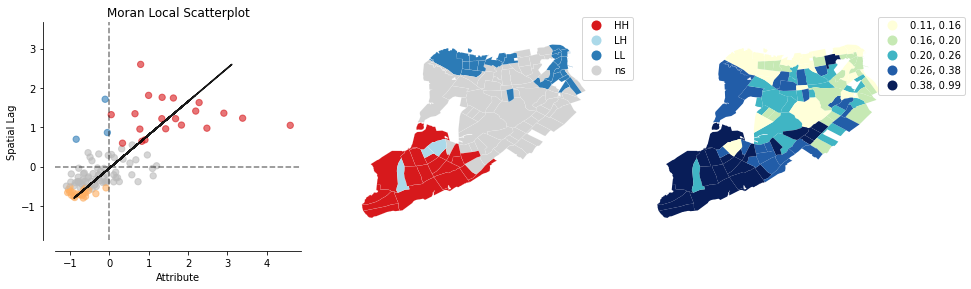

In [186]:
# plot results (at p < 0.05)
plot_local_autocorrelation(local_moran_SI2, SI_trees_cap_limit,'trees_per_capita', p = 0.05 );

plt.savefig("maps/StatenIsland/Staten-Island_Trees-per-Capita_limited_moran.pdf")

In [188]:
# get clusters and outliers
SI_trees_cap_limit['local_moran_Is'] = local_moran_SI2.Is
SI_trees_cap_limit['local_moran_p_value'] = local_moran_SI2.p_sim
SI_trees_cap_limit['local_moran_quadrant'] = local_moran_SI2.q

In [189]:
# get statisically significant clusters and outliers
alpha = 0.05
hotspots_SI2 = SI_trees_cap_limit.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 1")
coldspots_SI2 = SI_trees_cap_limit.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 3")
doughnuts_SI2 = SI_trees_cap_limit.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 2")
diamonds_SI2 = SI_trees_cap_limit.query(f"local_moran_p_value < {alpha} & local_moran_quadrant == 4")

/Users/djferrera/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


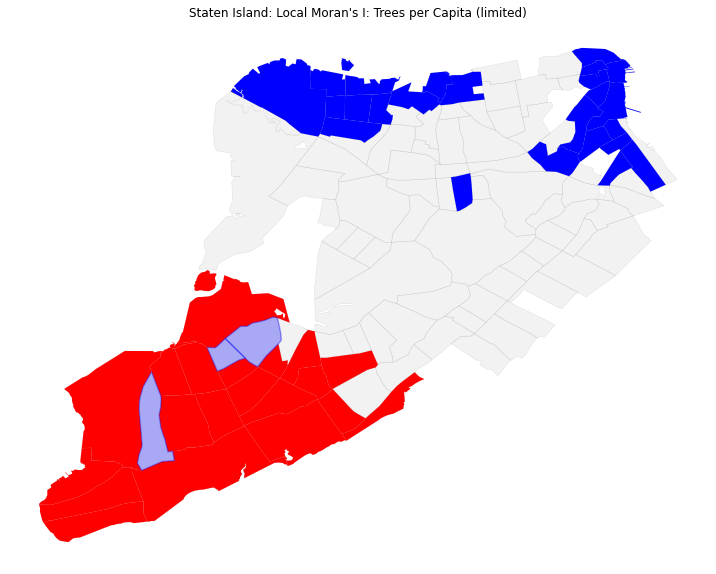

In [190]:
# view clusters and outliers

# create a figure with one subplot
fig, ax = plt.subplots(figsize=(20,10))

# plot census tracts
SI_trees_cap_limit.plot(ax = ax, alpha = 0.1, edgecolor = 'black', linewidth = 0.5, color = 'gray')

# plot HH / LL / HL / LH
SI_trees_cap_limit.plot(ax = ax, facecolor = 'none', alpha = 0)
hotspots_SI2.plot(color = 'red', ax = ax, label = 'Hot Spot')
coldspots_SI2.plot(color = 'blue', ax = ax, label = 'Cold Spot')
doughnuts_SI2.plot(color = 'blue', alpha = 0.3, edgecolor = 'blue', linewidth = 1.5, ax = ax, label = 'Doughnuts')
diamonds_SI2.plot(color = 'red', alpha = 0.3, edgecolor = 'red', linewidth = 1.5, ax = ax, label = 'Diamonds')

ax.axis('off')
ax.set(title = "Staten Island: Local Moran's I: Trees per Capita (limited)")

plt.savefig("maps/StatenIsland/Staten-Island_Trees-per-Capita_limited.pdf")